<a href="https://colab.research.google.com/github/carlibeisel/Drains_Lower_Boise_River/blob/main/*UBRB_precip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Carli Beisel

Purpose: This script extracts annual precipitation data from Google Earth Engine using the Earth Engine API in Python for the Upper Boise River Basin.



## Import packages/libraries and connect to Google drive

In [1]:
# Installs geemap package
import subprocess
!pip install geemap

try:
    import geemap
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

# Checks whether this notebook is running on Google Colab
try:
    import google.colab
    import geemap.eefolium as emap
except:
    import geemap as emap

# Authenticates and initializes Earth Engine
import ee

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project = 'extract-gridmet') #input and create project on google earth engiine

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [2]:
!pip install geopandas
import geopandas as gpd
import json
import os
import numpy as np
import pandas as pd
!pip install pycrs
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=156b3dac25a36d1e03acf9dd54272d65e3ef539db4677e70df61eaae08e9bb6b
  Stored in directory: /root/.cache/pip/wheels/47/1d/70/7a5bdf33347e7c75e95b06b1fa38f076a59a9506653cc24aff
Successfully built pycrs
Mounted at /content/drive


## Annual Precipitation Metric - Ignore

In [ ]:
## ------------------------------------------------- ##
##          ANNUAL PRECIPITATION METRIC              ##
## ------------------------------------------------- ##
ubrb = emap.shp_to_ee('/content/drive/MyDrive/Data/GIS Shapefiles/UBRB_shp/UBRB.shp')

years = np.arange(1987,2023)
annual_pr = []

for i in range(len(years)):
  daymet = ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate((str(years[i])+'-01-01'), (str(years[i])+'-12-31')) #get image collection for entire year
  pr = daymet.select('prcp').map(lambda image: image.clip(ubrb)).sum().set({'system:index': str(years[i])}) #select precip to analyze and sum
  annual_pr.append(pr)

annual_pr = ee.ImageCollection(annual_pr)


out_stats = os.path.join('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp_annual.csv')
emap.zonal_statistics(annual_pr, ubrb, out_stats, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp_annual.csv


## Water Year Precipitation for UBRB

In [10]:
## ------------------------------------------------- ##
##        WATER YEAR PRECIPITATION METRIC            ##
## ------------------------------------------------- ##

# NOTE: wy = Water Year: October 1 - September 30


ubrb = emap.shp_to_ee('/content/drive/MyDrive/Data/GIS Shapefiles/UBRB_shp/UBRB.shp')

years = np.arange(1987,2021)
wy_pr = []

for i in range(len(years)):
  daymet = ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate((str(years[i]-1)+'-10-01'), (str(years[i])+'-9-30')) #get image collection for water year
  pr = daymet.select('prcp').map(lambda image: image.clip(ubrb)).sum().set({'system:index': str(years[i])}) #select precip to analyze and sum
  wy_pr.append(pr)

wy_pr = ee.ImageCollection(wy_pr)


out_stats = os.path.join('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv')
emap.zonal_statistics(wy_pr, ubrb, out_stats, statistics_type='MEAN', scale=1000)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv


In [11]:
#---------------------#
#        Clean        #
#---------------------#
#Purpose: reorganize csv file to make manageable

#reload file
data = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv')

df = pd.DataFrame(data)
df = df.T #transpose df

# Set the first row as the column names
df.columns = df.iloc[0]
df = df[0:]
df = df.drop(df.index[34:]) #drop the last few lines of data description

# Reset index and rename columns
df = df.reset_index()
df.columns = ['year', 'precip']

# Remove '_prcp' from the 'year' column
df['year'] = df['year'].str.replace('_prcp', '')

print(df)

#save
df.to_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv', index=False)



    year       precip
0   1987   455.594757
1   1988   581.752842
2   1989   811.257562
3   1990   697.617133
4   1991   635.964474
5   1992   529.391393
6   1993   946.719241
7   1994   464.205542
8   1995  1000.792472
9   1996  1024.847633
10  1997  1142.974717
11  1998   909.621115
12  1999   816.455067
13  2000   718.422483
14  2001   528.239785
15  2002   684.037855
16  2003   748.441506
17  2004    758.56936
18  2005   655.419718
19  2006  1013.654967
20  2007   615.445898
21  2008   801.445982
22  2009   806.154641
23  2010   761.360128
24  2011   974.253765
25  2012   816.120382
26  2013   682.562276
27  2014   752.885802
28  2015   740.337847
29  2016    795.65167
30  2017  1207.162815
31  2018    715.07612
32  2019   920.166092
33  2020   645.069984


In [12]:
#---------------------#
#        Scale        #
#---------------------#
mean_precip = df['precip'].mean()
std_dev_precip = df['precip'].std()
df['precip_scaled'] = (df['precip'] - mean_precip) / std_dev_precip ** 2

df = df.reset_index(drop=True)
df.to_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp_scaled.csv', index=False)

In [13]:
# not needed?
## ---------------------------------------------------------------------- ##
##   IMPORT THE DAYMET DATA FOR PRECIPITATION PRIOR TO IRRIGATION SEASON  ##
## ---------------------------------------------------------------------- ##

years = np.arange(1987,2021)
ant_pr = []
for i in range(len(years)):
  daymet = ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate(str(years[i] - 1) + '-01-01', str(years[i] - 1) + '-12-31') #trying to get full year
  date = str(years[i]+1)
  print(date)
  prcp = daymet.select('prcp').map(lambda image: image.clip(ubrb)).sum().set({'system:index':date}) #select the bands to analyze
  ant_pr.append(prcp) #calculate the mean across all pixels

ant_precip = ee.ImageCollection(ant_pr) #convert list of image to image collection for zonal stats command

precip_vis = {
  'min': 0,
  'max': 544,
  'palette': ['1621A2', 'white', 'cyan', 'green', 'yellow', 'orange', 'red'],
}

Map = emap.Map(center=(43.6150, -116.2023),zoom=8)
Map.addLayer(ant_precip, precip_vis, 'prcp')
Map

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


Map(center=[43.615, -116.2023], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

Text(0, 0.5, 'Precipitation (units)')

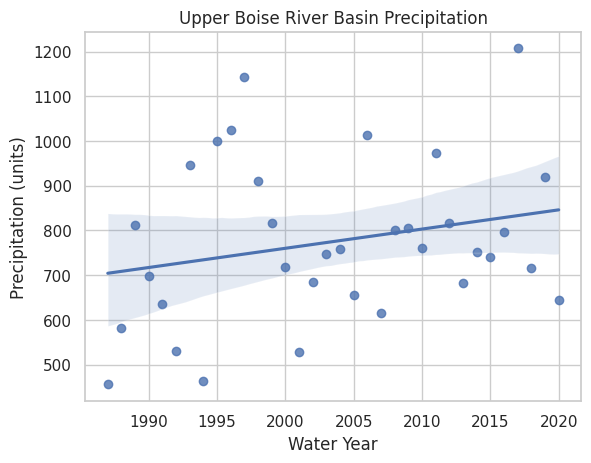

In [ ]:
## --------------------------------------------------- ##
##   Regresion Plot: UBRB Water Year Precipitation     ##
## --------------------------------------------------- ##

df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv')

sns.regplot(x=df["year"], y=df["precip"], marker='o', data=df)

plt.title('Upper Boise River Basin Precipitation')
plt.xlabel('Water Year')
plt.ylabel('Precipitation (units)')

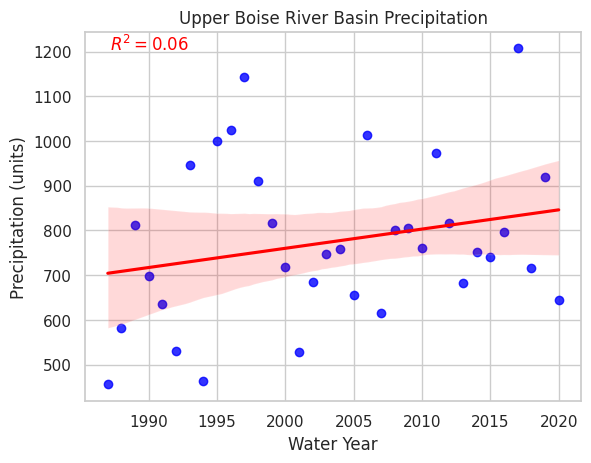

R^2 Coefficient: 0.06


In [ ]:
## --------------------------------------------------- ##
##   Regresion Plot: UBRB Water Year Precipitation     ##
## --------------------------------------------------- ##

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv')

# Prepare the data
X = df[['year']].values
y = df['precip'].values

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict using the model
y_pred = model.predict(X)

# Calculate the R^2 value
r_squared = r2_score(y, y_pred)

# Plot the data and the regression line
sns.regplot(x='year', y='precip', data=df, marker='o', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})

# Display the R^2 value on the plot
plt.text(0.05, 0.95, f'$R^2 = {r_squared:.2f}$', fontsize=12, color='red', transform=plt.gca().transAxes)

# Set plot labels and title
plt.title('Upper Boise River Basin Precipitation')
plt.xlabel('Water Year')
plt.ylabel('Precipitation (units)')

# Show plot
plt.show()

# Print the R^2 value
print(f'R^2 Coefficient: {r_squared:.2f}')

##**LBRB precip** : For reference

In [ ]:
# Load the shapefile
lbrb = emap.shp_to_ee('/content/drive/MyDrive/Data/GIS Shapefiles/LBRB_shp/LBRB_file.shp') # converts shapefile to feature in GEE


years = np.arange(1987,2021)
wy_pr = []

for i in range(len(years)):
  daymet = ee.ImageCollection("NASA/ORNL/DAYMET_V4").filterDate((str(years[i]-1)+'-10-01'), (str(years[i])+'-09-30')) #get image collection for entire year
  pr = daymet.select('prcp').map(lambda image: image.clip(lbrb)).sum().set({'system:index': str(years[i])}) #select precip to analyze and sum
  wy_pr.append(pr)

annual_pr = ee.ImageCollection(annual_pr)


out_stats = os.path.join('/content/drive/MyDrive/Data/Drains_Lower_Boise_River/data_output/UBRB_precip/lbrb_prcp.csv')
emap.zonal_statistics(wy_pr, lbrb, out_stats, statistics_type='MEAN', scale=1000)

The input raster must be an ee.Image.


In [ ]:
#---------------------#
#        Clean        #
#---------------------#
#Purpose: reorganize csv file to make manageable

#reload file
data = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/lbrb_prcp.csv')

df = pd.DataFrame(data)
df = df.T #transpose df

# Set the first row as the column names
df.columns = df.iloc[0]
df = df[0:]
df = df.drop(df.index[34:]) #drop the last few lines

# Reset the index and rename the columns
df = df.reset_index()
df.columns = ['year', 'precip']

# Remove '_prcp' from the 'year' column
df['year'] = df['year'].str.replace('_prcp', '')

print(df)

#save
df.to_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/lbrb_prcp.csv', index=False)

    year      precip
0   1987  238.186419
1   1988  306.726224
2   1989   280.76025
3   1990  298.771256
4   1991  327.468508
5   1992  258.749571
6   1993   376.00425
7   1994  296.914064
8   1995  450.663161
9   1996  468.764119
10  1997  328.024016
11  1998  495.514445
12  1999  279.300078
13  2000  370.760743
14  2001  272.833953
15  2002   230.64135
16  2003  332.117356
17  2004  343.096184
18  2005  408.899576
19  2006  380.253928
20  2007  267.032064
21  2008   289.95052
22  2009  352.342351
23  2010  470.775225
24  2011  353.620958
25  2012  326.602701
26  2013  263.689843
27  2014  458.571939
28  2015  419.454621
29  2016  303.420381
30  2017  477.338394
31  2018  304.462521
32  2019  418.222287
33  2020  416.708684


In [ ]:
#---------------------#
#        Scale        #
#---------------------#
mean_precip = df['precip'].mean()
std_dev_precip = df['precip'].std()
df['precip_scaled'] = (df['precip'] - mean_precip) / std_dev_precip ** 2

df = df.reset_index(drop=True)
df.to_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/lbrb_prcp_scaled.csv', index=False)

## Comparison of UBRB & LBRB Water Year Precip

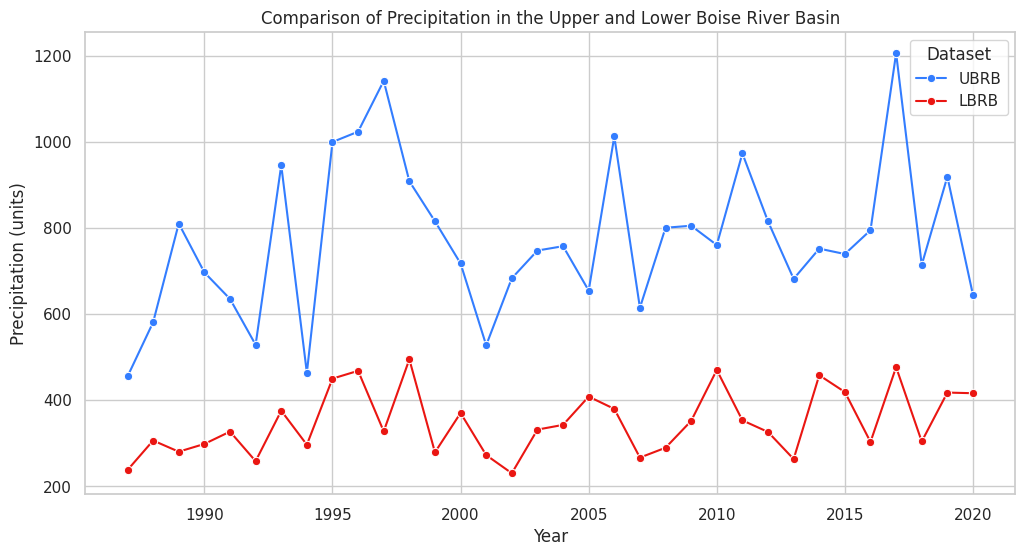

In [ ]:
ubrb = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/ubrb_prcp.csv')
lbrb = pd.read_csv('/content/drive/MyDrive/Data/Model Modifications/UBRB_precip/lbrb_prcp.csv')

# Add an identifier column to each DataFrame
ubrb['Dataset'] = 'UBRB'
lbrb['Dataset'] = 'LBRB'

# Combine the datasets into one DataFrame
combined_df = pd.concat([ubrb, lbrb])


plt.figure(figsize=(12, 6))

#specify color
palette = {'UBRB': '#337DFF',  # Blue
           'LBRB': '#EA1612'}  # Red

sns.lineplot(x='year', y='precip', hue='Dataset', data=combined_df, palette=palette, marker='o')

plt.title('Comparison of Precipitation in the Upper and Lower Boise River Basin')
plt.xlabel('Year')
plt.ylabel('Precipitation (units)')
plt.legend(title='Dataset')

plt.savefig('/content/drive/MyDrive/Carli Thesis/Figures/Model Figures/UBRB_LBRB_WY_Precip.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()
plt.close()